# File Preprocessing  

In [1]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt

In [2]:
cwd_path = Path.cwd()

In [3]:
og_train_path = os.path.join(cwd_path, "fruits-360/Training")
og_test_path  = os.path.join(cwd_path, "fruits-360/Test")

In [4]:
def getRandomFruitDirs(classCount):
    return np.random.choice(os.listdir(og_train_path), classCount, replace=False)

In [5]:
def MakeDirs(srcDir, newDirs):
    
    if type(newDirs) == str: 
        dirpath = os.path.join(srcDir, newDirs)
        if os.path.isdir(dirpath): 
            shutil.rmtree(dirpath)
        
        os.mkdir(dirpath)
    
    
    if type(newDirs) == list:    
        for dirname in newDirs:
            dirpath = os.path.join(srcDir, dirname)
            if os.path.isdir(dirpath):
                shutil.rmtree(dirpath)
        
            os.mkdir(dirpath)

In [6]:
def transferFile(srcPaths, destDir):
    if not os.path.isdir(destDir):     
        os.mkdir(destDir)
        
    for idx, imagePth in enumerate(srcPaths): 
        dPath = os.path.join(destDir, f"img{idx}.jpg")
        os.symlink(imagePth, dPath)
    

In [7]:
def getImageMatrix(links, title, image_size):

    sub_matrix = np.zeros(image_size[0] * image_size[1] * 3)
    labels = []
    for link in links: 
        vect_item = cv2.imread(link)
        vect_item = cv2.resize(vect_item, image_size)
        vect_item = cv2.cvtColor(vect_item, cv2.COLOR_BGR2RGB)
        sub_matrix = np.vstack((sub_matrix, vect_item.flatten()))
        labels.append(title)
        
    return sub_matrix[1:]/255, np.array(labels)

In [8]:
def getSamplesDir(sampleSize, valSize, testSize, selectedFruits, classDist = None): 
    trainSize = 1 - (valSize + testSize)
    train_fn = []
    test_fn = []
    val_fn = []

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")

        
    if testSize <= 0: 
        raise Exception("Training sample size too small!")

    train_sample_sz = int(trainSize * sampleSize)
    val_sample_sz = int(valSize * sampleSize) 
    test_sample_sz = int(testSize * sampleSize)

    subset_dir = "ML_FINAL_PROJECT/fruits-360"
    MakeDirs(subset_dir, "Subsets")
    
    subset_dir = "ML_FINAL_PROJECT/fruits-360/Subsets"
    
    subs = ["Train_sub", "Validation_sub", "Test_sub"]
    MakeDirs("ML_FINAL_PROJECT/fruits-360/Subsets", subs)

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        train_fn = np.random.choice(globbed_train, int(train_sample_sz * cDist[idx]), replace = False)
        testval_fn = np.random.choice(globbed_test, int((test_sample_sz  + val_sample_sz)*cDist[idx]), replace = False)

        test_fn, val_fn = testval_fn[ : int(test_sample_sz * cDist[idx])],  testval_fn[int(test_sample_sz * cDist[idx]) + 1 :]
        
        transferFile(train_fn, os.path.join(subset_dir, subs[0], fruit))
        transferFile(val_fn, os.path.join(subset_dir, subs[1], fruit))
        transferFile(test_fn, os.path.join(subset_dir, subs[2], fruit)) 

In [9]:
def getSamplesMat(sampleSize, selectedFruits, classDist = None, resize = (100, 100)): 
    matrix = np.zeros(shape = (1, resize[0] * resize[1] * 3))
    labels = np.zeros(0)

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")
        return 
        

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        fn = np.random.choice(globbed_train + globbed_test, int(sampleSize * cDist[idx]) ,replace = False)
        res_matrix, new_labels = getImageMatrix(fn, fruit,resize)        
        
        matrix = np.vstack([matrix, res_matrix])
        labels = np.concatenate([labels, new_labels])
        
    return matrix[1:], labels, fn[0]

In [10]:
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv

# ANN

## Testing similar color but different shapes

In [11]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop, Nadam

sample_size = 500
classDist = None
resizes = (20,20)

C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.0686 - loss: 3.1483 - val_accuracy: 0.0375 - val_loss: 3.1566
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2140 - loss: 2.6915 - val_accuracy: 0.2000 - val_loss: 2.4554
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3471 - loss: 1.9510 - val_accuracy: 0.3875 - val_loss: 1.7713
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6748 - loss: 1.2629 - val_accuracy: 0.5625 - val_loss: 1.3296
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7004 - loss: 0.9303 - val_accuracy: 0.6000 - val_loss: 1.1749
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8326 - loss: 0.6180 - val_accuracy: 0.7625 - val_loss: 0.7043
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9105 - loss: 0.3293 - val_accuracy: 0.7875 - val_loss: 0.5973
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9100 - loss: 0.2696 - val_accuracy: 0.8125 - v

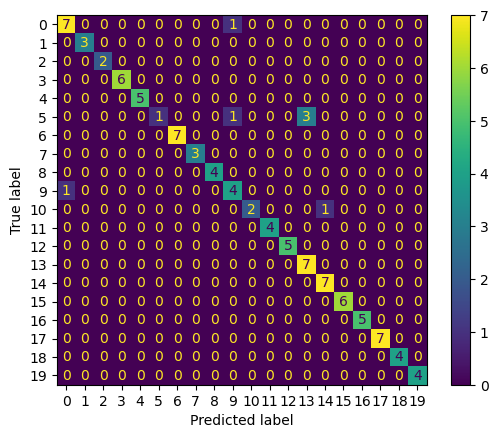

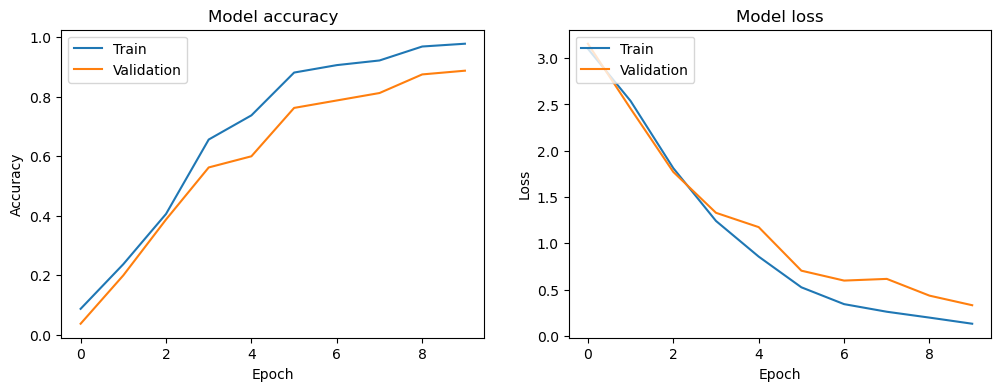

In [12]:
#Testing Red Fruits
fruits = [
    "Grape Pink", "Tomato Cherry Red", "Tomato Maroon", "Apple Pink Lady", "Apricot",
    "Tomato 1", "Peach", "Cherry 2", "Apple Braeburn", "Tomato Heart",
    "Pepper Red", "Pomegranate", "Mango Red", "Pear Red", "Kaki", "Onion Red",
    "Strawberry", "Tamarillo", "Cucumber Ripe", "Pear Forelle"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.0794 - loss: 3.0340 - val_accuracy: 0.2000 - val_loss: 2.7669
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2746 - loss: 2.4747 - val_accuracy: 0.3125 - val_loss: 2.1959
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4080 - loss: 1.9080 - val_accuracy: 0.6125 - val_loss: 1.4858
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5470 - loss: 1.3528 - val_accuracy: 0.6500 - val_loss: 1.2666
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6593 - loss: 1.0921 - val_accuracy: 0.6875 - val_loss: 1.0513
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6819 - loss: 0.9364 - val_accuracy: 0.7000 - val_loss: 0.9274
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8167 - loss: 0.6334 - val_accuracy: 0.7625 - val_loss: 0.8680
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8500 - loss: 0.5310 - val_accuracy: 0.7750 - val_loss: 0.

C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


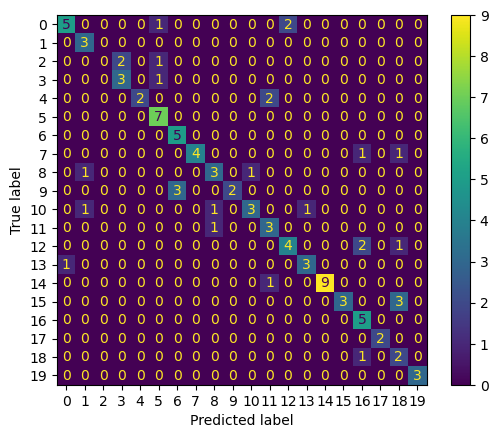

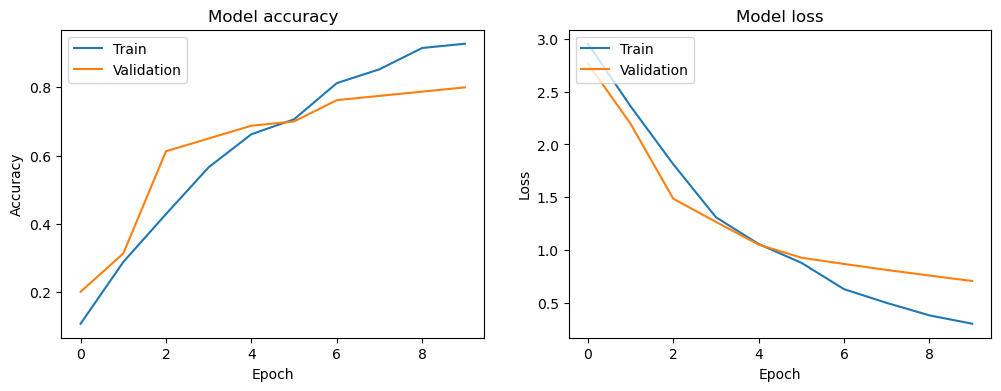

In [13]:
#Testing Red Fruits (greyscaled)
fruits = [
    "Grape Pink", "Tomato Cherry Red", "Tomato Maroon", "Apple Pink Lady", "Apricot",
    "Tomato 1", "Peach", "Cherry 2", "Apple Braeburn", "Tomato Heart",
    "Pepper Red", "Pomegranate", "Mango Red", "Pear Red", "Kaki", "Onion Red",
    "Strawberry", "Tamarillo", "Cucumber Ripe", "Pear Forelle"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.0436 - loss: 3.3392 - val_accuracy: 0.0750 - val_loss: 2.8403
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1870 - loss: 2.7033 - val_accuracy: 0.1750 - val_loss: 2.5299
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2943 - loss: 2.1891 - val_accuracy: 0.3125 - val_loss: 2.0581
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4656 - loss: 1.6723 - val_accuracy: 0.5500 - val_loss: 1.3876
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7382 - loss: 1.0121 - val_accuracy: 0.6875 - val_loss: 1.0040
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8434 - loss: 0.7459 - val_accuracy: 0.6125 - val_loss: 0.8681
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8604 - loss: 0.5281 - val_accuracy: 0.8625 - val_loss: 0.5395
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9112 - loss: 0.3384 - val_accuracy: 0.8000 - val_loss: 0.

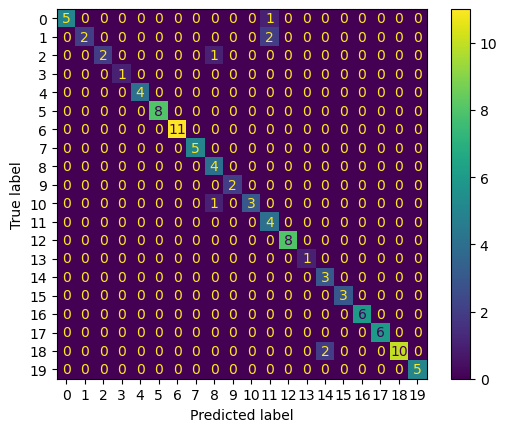

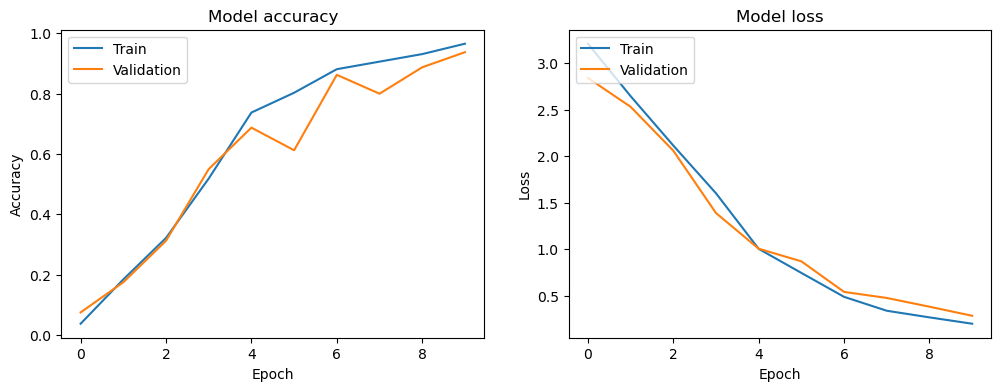

In [14]:
#Yellow/Orange
fruits = [
    "Pepper Yellow", "Grapefruit Pink", "Tomato Yellow", "Mandarine", "Tangelo",
    "Grapefruit White", "Cherry Wax Yellow", "Kaki", "Peach 2", "Apple Red Yellow 1",
    "Lemon", "Pomelo Sweetie", "Pear Red", "Pepper Orange", "Peach", "Maracuja", 
    "Apricot", "Cucumber Ripe 2", "Carambula", "Tomato 2"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0575 - loss: 3.1102 - val_accuracy: 0.1250 - val_loss: 2.9904
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1948 - loss: 2.6878 - val_accuracy: 0.1375 - val_loss: 2.6384
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2971 - loss: 2.3225 - val_accuracy: 0.3625 - val_loss: 1.9602
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4947 - loss: 1.6410 - val_accuracy: 0.4750 - val_loss: 1.6658
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5928 - loss: 1.3316 - val_accuracy: 0.5750 - val_loss: 1.3600
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6841 - loss: 1.0313 - val_accuracy: 0.4875 - val_loss: 1.3570
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7057 - loss: 0.8800 - val_accuracy: 0.6000 - val_loss: 1.0557
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7827 - loss: 0.7177 - val_accuracy: 0.5750 - val_loss: 1.

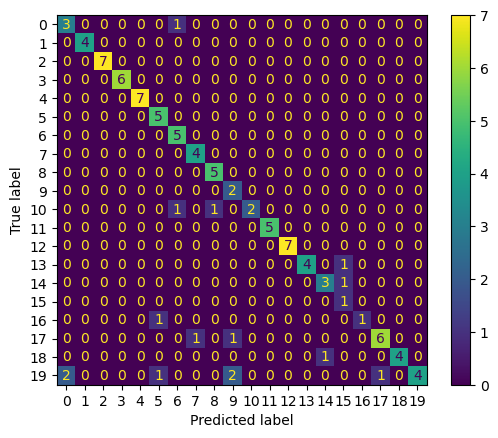

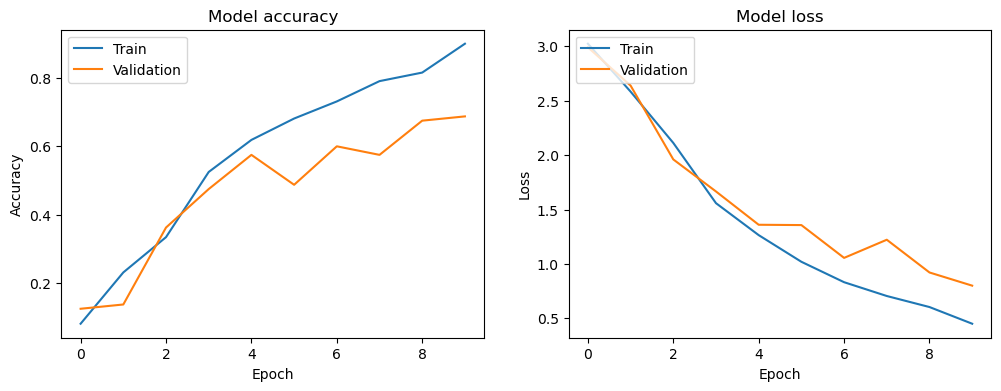

In [15]:
#Yellow/Orange (greyscaled)
fruits = [
    "Pepper Yellow", "Grapefruit Pink", "Tomato Yellow", "Mandarine", "Tangelo",
    "Grapefruit White", "Cherry Wax Yellow", "Kaki", "Peach 2", "Apple Red Yellow 1",
    "Lemon", "Pomelo Sweetie", "Pear Red", "Pepper Orange", "Peach", "Maracuja", 
    "Apricot", "Cucumber Ripe 2", "Carambula", "Tomato 2"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1012 - loss: 3.0988 - val_accuracy: 0.2625 - val_loss: 2.3571
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3510 - loss: 2.1399 - val_accuracy: 0.2625 - val_loss: 1.9649
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5731 - loss: 1.3652 - val_accuracy: 0.7250 - val_loss: 0.9559
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8096 - loss: 0.7359 - val_accuracy: 0.8000 - val_loss: 0.6819
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8348 - loss: 0.5149 - val_accuracy: 0.8250 - val_loss: 0.5618
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9422 - loss: 0.2702 - val_accuracy: 0.9250 - val_loss: 0.2902
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9538 - loss: 0.1677 - val_accuracy: 0.9250 - val_loss: 0.2785
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9411 - loss: 0.1664 - val_accuracy: 0.9500 - val_loss: 0.

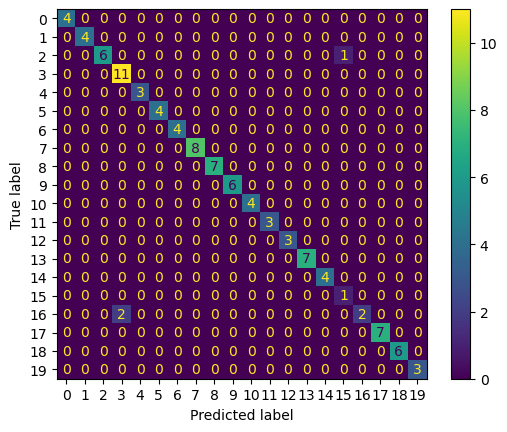

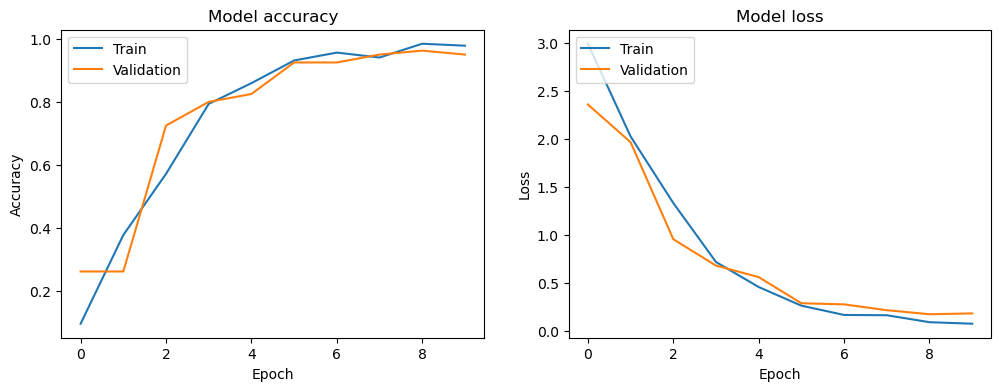

In [16]:
#Testing Green Fruits
fruits = ['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Avocado', 'Grape White 3',
         'Cherry Wax Black', 'Blueberry', 'Cherry 1', 'Plum 3', 'Plum',
         'Nut Forest', 'Mango', 'Pomelo Sweetie', 'Limes', 'Pineapple',
         'Apple Granny Smith', 'Guava', 'Watermelon', 'Apple Golden 3']
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1009 - loss: 2.9494 - val_accuracy: 0.3375 - val_loss: 2.6316
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2807 - loss: 2.3995 - val_accuracy: 0.3500 - val_loss: 2.0164
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4444 - loss: 1.6856 - val_accuracy: 0.4625 - val_loss: 1.4730
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5820 - loss: 1.2559 - val_accuracy: 0.7125 - val_loss: 0.9555
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7439 - loss: 0.8502 - val_accuracy: 0.7625 - val_loss: 0.8439
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7524 - loss: 0.7137 - val_accuracy: 0.7250 - val_loss: 0.7569
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8718 - loss: 0.4368 - val_accuracy: 0.8000 - val_loss: 0.6240
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8822 - loss: 0.3969 - val_accuracy: 0.8500 - val_loss: 0.

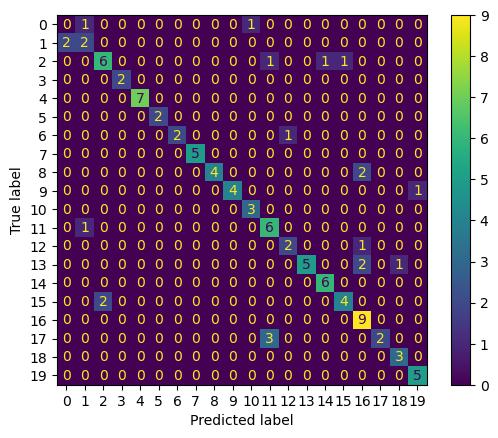

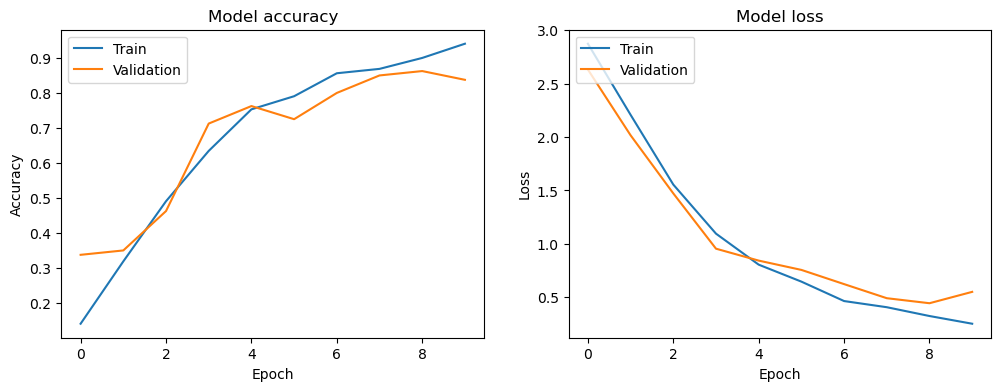

In [17]:
#Testing Green Fruits (greyscaled)
fruits = ['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Avocado', 'Grape White 3',
         'Cherry Wax Black', 'Blueberry', 'Cherry 1', 'Plum 3', 'Plum',
         'Nut Forest', 'Mango', 'Pomelo Sweetie', 'Limes', 'Pineapple',
         'Apple Granny Smith', 'Guava', 'Watermelon', 'Apple Golden 3']
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)
X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing similar shape but different colors

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1068 - loss: 3.0506 - val_accuracy: 0.3250 - val_loss: 2.2618
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2989 - loss: 2.0993 - val_accuracy: 0.5125 - val_loss: 1.5132
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6275 - loss: 1.2336 - val_accuracy: 0.7125 - val_loss: 0.9166
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7399 - loss: 0.8033 - val_accuracy: 0.8125 - val_loss: 0.5135
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8129 - loss: 0.5418 - val_accuracy: 0.8750 - val_loss: 0.3272
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9498 - loss: 0.2408 - val_accuracy: 0.9875 - val_loss: 0.1528
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9665 - loss: 0.1829 - val_accuracy: 0.9375 - val_loss: 0.1756
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0964 - val_accuracy: 0.9625 - val_loss: 0.

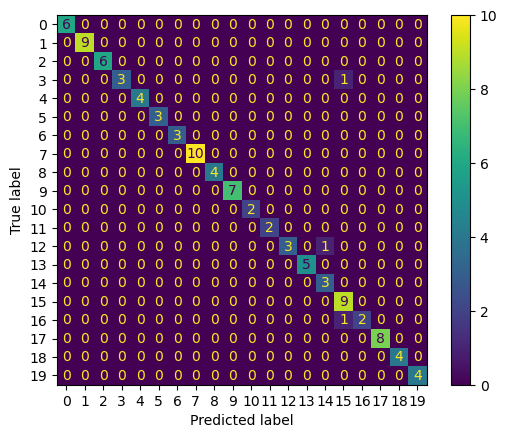

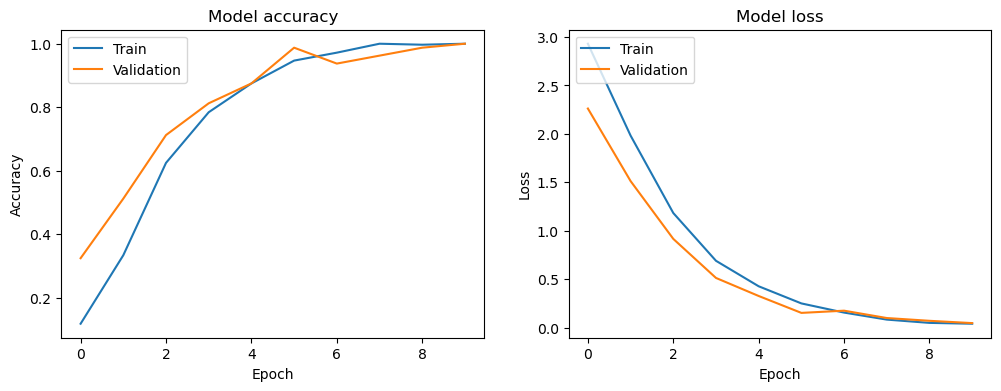

In [18]:
#Testing circular fruits
fruits = [
    "Cantaloupe 1", "Cantaloupe 2", "Cherry 1", "Cherry 2", "Apricot",
    "Cherry Wax Black", "Cherry Wax Red", "Cherry Wax Yellow", "Clementine",
    "Grape Blue", "Grape White", "Grapefruit Pink", "Nectarine", "Orange",
    "Peach", "Plum", "Plum 2", "Tomato Cherry Red", "Walnut", "Watermelon"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1010 - loss: 3.1087 - val_accuracy: 0.1625 - val_loss: 2.4994
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2752 - loss: 2.3622 - val_accuracy: 0.3000 - val_loss: 1.9673
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4038 - loss: 1.7676 - val_accuracy: 0.5250 - val_loss: 1.2090
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6927 - loss: 1.0469 - val_accuracy: 0.8500 - val_loss: 0.6166
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7892 - loss: 0.7244 - val_accuracy: 0.8625 - val_loss: 0.5041
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8892 - loss: 0.4835 - val_accuracy: 0.8750 - val_loss: 0.4001
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8985 - loss: 0.3189 - val_accuracy: 0.9875 - val_loss: 0.2372
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9571 - loss: 0.1841 - val_accuracy: 0.9625 - val_loss: 0.

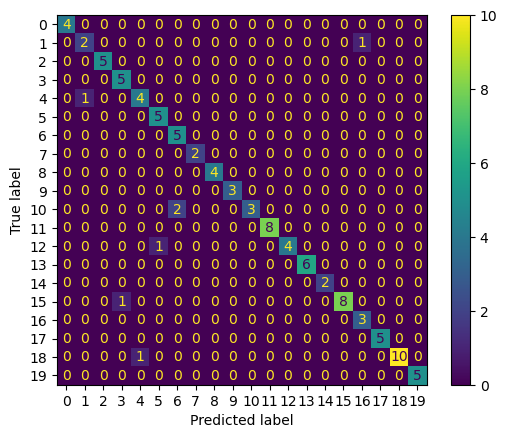

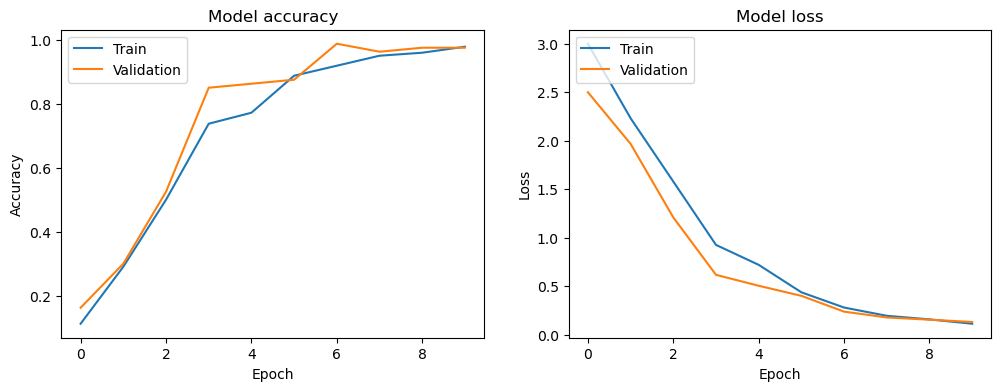

In [19]:
#Testing not quite Circular Fruits
fruits = [
    "Apple Braeburn", "Apple Crimson Snow", "Apple Golden 1", "Apple Granny Smith",
    "Apple Pink Lady", "Apple Red 1", "Apple Red Delicious", "Apple Red Yellow 1",
    "Beetroot", "Blueberry", "Fig", "Guava", "Lemon", "Limes", "Onion Red",
    "Onion White", "Pepper Red", "Lemon Meyer", "Mango Red", "Kiwi"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.0554 - loss: 3.2846 - val_accuracy: 0.0375 - val_loss: 2.9546
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1428 - loss: 2.7638 - val_accuracy: 0.2500 - val_loss: 2.5865
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2737 - loss: 2.3442 - val_accuracy: 0.3625 - val_loss: 2.0053
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4312 - loss: 1.8270 - val_accuracy: 0.5000 - val_loss: 1.6446
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6290 - loss: 1.3653 - val_accuracy: 0.5250 - val_loss: 1.4786
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6330 - loss: 1.1384 - val_accuracy: 0.6500 - val_loss: 1.1279
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7308 - loss: 0.8160 - val_accuracy: 0.7125 - val_loss: 1.0407
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7839 - loss: 0.7859 - val_accuracy: 0.7250 - val_loss: 0.

C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\John\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


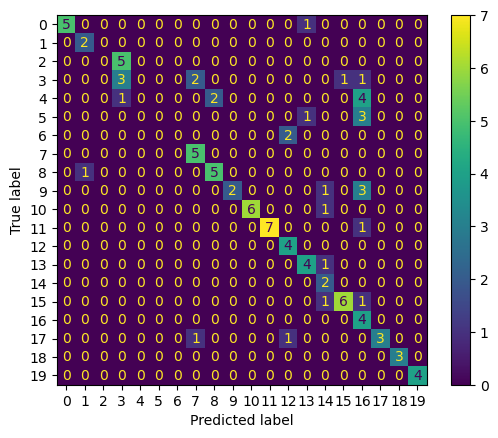

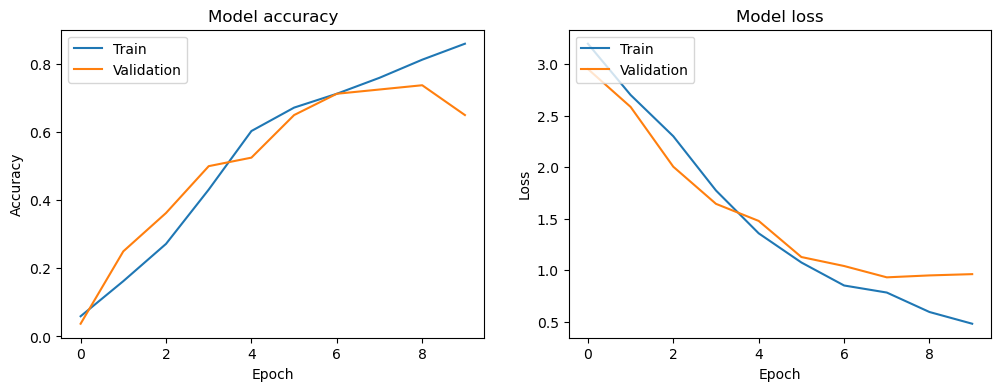

In [20]:
#Testing Tubular Fruits
fruits = [
    "Eggplant", "Avocado", "Avocado Ripe", "Banana", "Banana Lady Finger", "Banana Red",
    "Cactus fruit", "Carambula", "Corn", "Cucumber Ripe", "Hazelnut", "Kumquats",
    "Pear 2", "Pear Red", "Pepino", "Tomato 2", "Nut Pecan", "Melon Piel de Sapo",
    "Pear Abate", "Corn Husk"
]
fruits = np.array(fruits)

image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, trainClassDistSix, resizes)
#X_train, ignore, y_train, disregard = train_test_split(image_dataset, labels, test_size=0.2)

#image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
#ignore, X_test, disregard, y_test = train_test_split(image_dataset, labels, test_size=0.2)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Random Fruits

In [21]:
count = 40
sample_size = 1000

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.0382 - loss: 3.8008 - val_accuracy: 0.1625 - val_loss: 3.2650
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1948 - loss: 2.9819 - val_accuracy: 0.3562 - val_loss: 2.3294
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4477 - loss: 1.9417 - val_accuracy: 0.4563 - val_loss: 1.7134
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5975 - loss: 1.2716 - val_accuracy: 0.6125 - val_loss: 1.3964
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7560 - loss: 0.8736 - val_accuracy: 0.7188 - val_loss: 1.0093
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7781 - loss: 0.6836 - val_accuracy: 0.7500 - val_loss: 0.8648
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8548 - loss: 0.5102 - val_accuracy: 0.7437 - val_loss: 0.9686
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8960 - loss: 0.3849 - val_accuracy: 0.7875 - val_loss: 0.

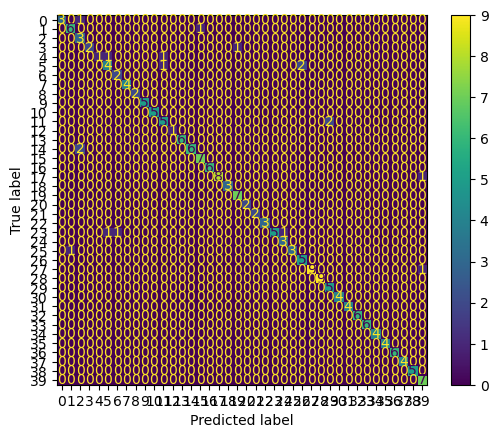

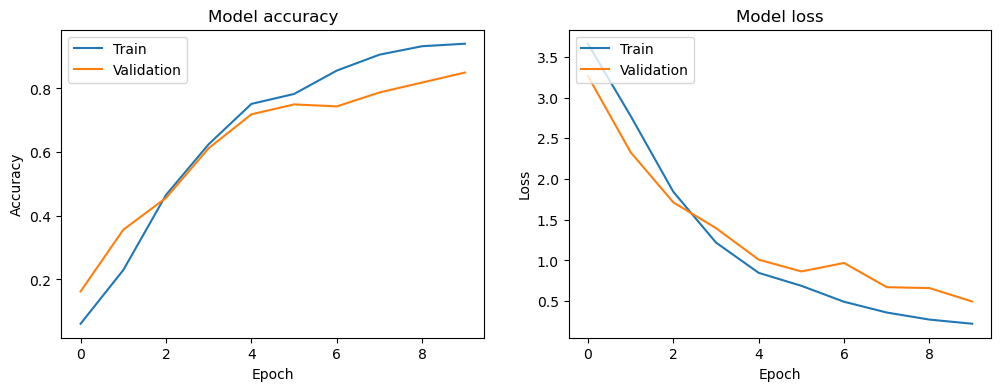

In [22]:
#Random Fruits 1
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.0483 - loss: 3.7820 - val_accuracy: 0.1937 - val_loss: 3.1825
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2034 - loss: 2.9393 - val_accuracy: 0.4125 - val_loss: 2.1501
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4769 - loss: 1.8318 - val_accuracy: 0.6625 - val_loss: 1.2680
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7238 - loss: 1.0046 - val_accuracy: 0.7063 - val_loss: 0.9762
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8530 - loss: 0.5573 - val_accuracy: 0.8875 - val_loss: 0.4888
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9076 - loss: 0.4045 - val_accuracy: 0.8562 - val_loss: 0.5205
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9376 - loss: 0.2793 - val_accuracy: 0.9062 - val_loss: 0.3218
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9529 - loss: 0.2055 - val_accuracy: 0.8813 - val_loss: 0.

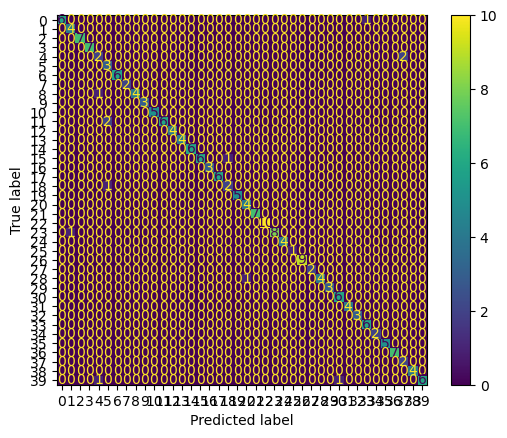

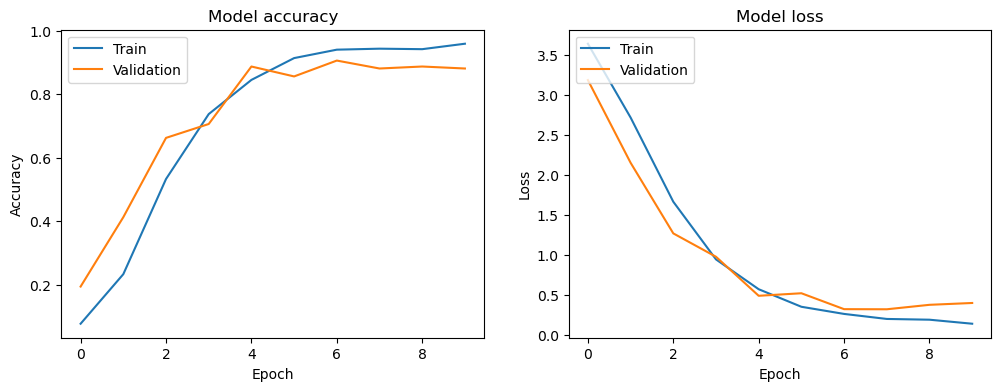

In [23]:
#Random Fruits 2
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


C:\Users\John\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0284 - loss: 3.8226 - val_accuracy: 0.1250 - val_loss: 3.1484
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2150 - loss: 2.8725 - val_accuracy: 0.3625 - val_loss: 2.0916
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4232 - loss: 1.8476 - val_accuracy: 0.6125 - val_loss: 1.3634
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6556 - loss: 1.1680 - val_accuracy: 0.6875 - val_loss: 1.0546
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8210 - loss: 0.6941 - val_accuracy: 0.7063 - val_loss: 0.9932
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8353 - loss: 0.5831 - val_accuracy: 0.8188 - val_loss: 0.7367
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9276 - loss: 0.3444 - val_accuracy: 0.8062 - val_loss: 0.7938
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9118 - loss: 0.3090 - val_accuracy: 0.8125 - val_loss: 0.

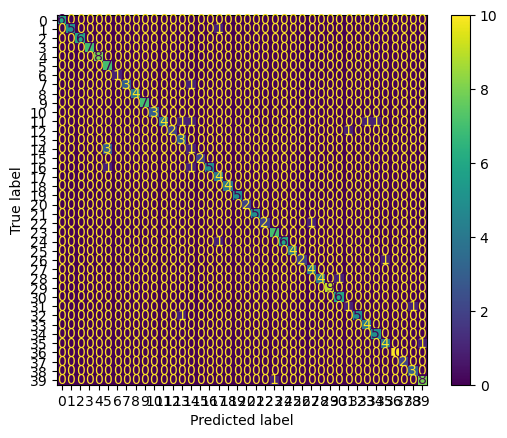

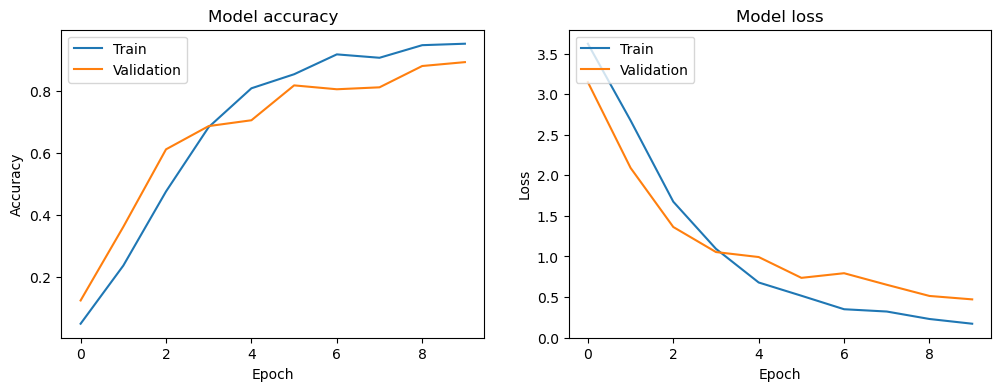

In [24]:
#Random Fruits 3
fruits = getRandomFruitDirs(count)
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# ANN Model
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(resizes[0] * resizes[1] * 3,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(fruits), activation='softmax')
])

ann_model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, y_pred_ann, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test_encoded, y_pred_ann)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()